<h1><strong>케라스로 KorQuAD 구현하기</strong></h1>


## **bert모델 다운로드**

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2021-06-23 14:29:50--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.4’

multi_cased_L-12_H- 100%[===================>] 632.19M  59.2MB/s    in 11s     

2021-06-23 14:30:02 (60.1 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.4’ saved [662903077/662903077]



## **케라스 모델 버전 설치**
## **케라스에서 keras-bert, keras-radam 설치**

In [ ]:
!pip install keras-transformer==0.32.0
!pip install keras-bert==0.81.0
!pip install keras-radam==0.15.0

## **colab에 bert디렉토리를 만듦**

## **다운로드 받은 bert모델을 bert 폴더에 압축품**

In [ ]:
import os
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

## **bert폴더로 통체로 복사**

In [ ]:
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

### bert로 학습시킬 squad의 train, dev 데이터를 다운받는다.

In [ ]:
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json

--2021-06-23 14:30:23--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [text/plain]
Saving to: ‘train-v1.1.json.4’

train-v1.1.json.4   100%[===================>]  28.88M  53.5MB/s    in 0.5s    

2021-06-23 14:30:28 (53.5 MB/s) - ‘train-v1.1.json.4’ saved [30288272/30288272]

--2021-06-23 14:30:28--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 

## **폴더의 데이터를 본다**

In [ ]:
os.listdir()

['.config',
 'multi_cased_L-12_H-768_A-12.zip.2',
 'train-v1.1.json.4',
 'multi_cased_L-12_H-768_A-12.zip.4',
 'my_answer.csv',
 'dev-v1.1.json.3',
 'drive',
 'train-v1.1.json',
 'bert',
 'multi_cased_L-12_H-768_A-12.zip.3',
 'multi_cased_L-12_H-768_A-12.zip.1',
 'dev-v1.1.json.1',
 'train-v1.1.json.1',
 'gdrive',
 'dev-v1.1.json',
 'train-v1.1.json.3',
 'train-v1.1.json.2',
 'dev-v1.1.json.4',
 'multi_cased_L-12_H-768_A-12.zip',
 'dev-v1.1.json.2',
 'sample_data']


##**구글 드라이브와 Colab을 연동함**

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## **구글 드라이브내에 squad 폴더를 지정함.**

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/squad"

## **구글드라이브내 내 드라이브를 연동함**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <h2><strong>케라스와 버트를 활동, KorQUAD 모델을 만듦.</strong></h2>

## **텐서플로우, 판다스, 넘파이, 케라스, JSON 등 필요한 모듈들을 임포트함**

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

## **warning 무시**

In [ ]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

## **keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트**
# Radam, Adamwarmup, Tokenizer
# **keras-radam은 모델을 훈련시킬 때, learning_rate을 점진적으로 목표값까지 올려주는 훈련을 시키는 옵티마이저이다.**

In [ ]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

## **JSON파일을 PANDAS DATAFRAME으로 만들어주는 함수를 정의.**

In [ ]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

## **KorQUAD 데이터를 PANDAS DATAFRAME 형식으로 로드**

In [ ]:
train = squad_json_to_dataframe_train(path+"/KorQuAD_v1.0_train.json")

Reading the json file
processing...
shape of the dataframe is (60407, 6)
Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **train데이터 데이터 프레임**

In [ ]:
train

,index,question,context,text,answer_start,c_id
0,6566495-0-0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,54,0
1,6566495-0-1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,421,0
2,6566495-0-2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,194,0
3,6566518-0-0,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,15,0
4,6566518-0-1,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,354,0
...,...,...,...,...,...,...
60402,6467478-1-1,뉴델리 메탈로 베타락마제가 처음 감염 된 지역은 어디인가?,"유전자의 이름은 인도의 수도 뉴델리의 이름을 따 붙여졌는데, 이는 2009년 용 (...",인도,73,9604
60403,6467478-2-0,균은 유전자를 균에게 전달 할 수있는데 이러한 현상을 나타낸 용어는 무엇인가?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",유전자 전달,253,9605
60404,6467478-2-1,박테리아가 NDM-1 유전자를 가지고 있을때 발생하는 전파를 분석하기위해 사용된 영...,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",37건,129,9605
60405,6490801-2-0,NDM-1 유전자를 가진 박테리아가 감수성을 보인 폴리믹슨 계열 항생제는?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",콜리스틴,404,9605



## - bert 훈련을 위한 사전 설정을 함.
##SEQ_LEN은 문장의 최대 길이
##SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 ##SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됨  

##- BATCH_SIZE는 10, 총 훈련 에포크 수는 1, 학습율(LR;Learning rate)은 3e-5

## - pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미함.

In [ ]:
SEQ_LEN = 3000
BATCH_SIZE = 10
EPOCHS=1
LR=3e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "context"
QUESTION_COLUMN = "question"
TEXT = "text"

##vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성함.
##우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됨.

In [ ]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

# - BERT의 토큰화는 단어를 분리하는 토큰화 방식임 wordpiece 방식이라고 하는데, 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있음.
# - 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징임.  
# - 토크나이저 클래스를 상속을 받아서, 토크나이저를 재정의 해주어야 함.

# 버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치함.
# [CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미함.

In [ ]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [ ]:
tokenizer = inherit_Tokenizer(token_dict)

In [ ]:
token_dict

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

token dict의 key 값과 value 값을 바꾼 reverse_token_dict를 정의함.

In [ ]:
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [ ]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused1]',
 2: '[unused2]',
 3: '[unused3]',
 4: '[unused4]',
 5: '[unused5]',
 6: '[unused6]',
 7: '[unused7]',
 8: '[unused8]',
 9: '[unused9]',
 10: '[unused10]',
 11: '[unused11]',
 12: '[unused12]',
 13: '[unused13]',
 14: '[unused14]',
 15: '[unused15]',
 16: '[unused16]',
 17: '[unused17]',
 18: '[unused18]',
 19: '[unused19]',
 20: '[unused20]',
 21: '[unused21]',
 22: '[unused22]',
 23: '[unused23]',
 24: '[unused24]',
 25: '[unused25]',
 26: '[unused26]',
 27: '[unused27]',
 28: '[unused28]',
 29: '[unused29]',
 30: '[unused30]',
 31: '[unused31]',
 32: '[unused32]',
 33: '[unused33]',
 34: '[unused34]',
 35: '[unused35]',
 36: '[unused36]',
 37: '[unused37]',
 38: '[unused38]',
 39: '[unused39]',
 40: '[unused40]',
 41: '[unused41]',
 42: '[unused42]',
 43: '[unused43]',
 44: '[unused44]',
 45: '[unused45]',
 46: '[unused46]',
 47: '[unused47]',
 48: '[unused48]',
 49: '[unused49]',
 50: '[unused50]',
 51: '[unused51]',
 52: '[unused52]',
 53: '[unused53]'

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됨.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴다.
세그먼트는 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것이다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.


![대체 텍스트](https://i.imgur.com/l9BTao3.png)

In [ ]:
question = train['question'][100]
context = train['context'][100]
text = train['text'][100]

In [ ]:
# 질문
question

'바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'

In [ ]:
# 문장
context

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [ ]:
# 정답
text

'교향곡'

토크나이저

In [ ]:
print(tokenizer.tokenize(question, context))

['[CLS]', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트를', '읽', '##고', '무', '##엇', '##을', '쓰', '##고', '##자', '했', '##는', '##가', '?', '[SEP]', '1839', '##년', '바', '##그', '##너', '##는', '괴', '##테', '##의', '파', '##우스', '##트', '##을', '처음', '읽', '##고', '그', '내', '##용', '##에', '마', '##음', '##이', '끌', '##려', '이를', '소', '##재', '##로', '해', '##서', '하나의', '교', '##향', '##곡', '##을', '쓰', '##려', '##는', '뜻', '##을', '갖', '##는다', '.', '이', '시', '##기', '바', '##그', '##너', '##는', '1838', '##년에', '빛', '독', '##촉', '##으로', '산', '##전', '##수', '##전을', '다', '걲', '##은', '상', '##황', '##이', '##라', '좌', '##절', '##과', '실', '##망', '##에', '가', '##득', '##했으며', '메', '##피', '##스', '##토', '##펠', '##레스', '##를', '만', '##나는', '파', '##우스', '##트', '##의', '심', '##경', '##에', '공', '##감', '##했다', '##고', '한다', '.', '또한', '파', '##리에', '##서', '아', '##브', '##네', '##크', '##의', '지', '##휘', '##로', '파', '##리', '음악', '##원', '관', '##현', '##악', '##단', '##이', '연', '##주', '##하는', '베', '##토', '##벤', '##의', '교', '##향', '##곡', '9'

In [ ]:
print(tokenizer.tokenize(text))

['[CLS]', '교', '##향', '##곡', '[SEP]']


# convert_data 함수에서, 정답(text) 길이만큼 문장(context)를 슬라이딩 하면서 만약에 문장이 정답을 포함하는 위치에 도달하면, 문장에서 정답의 맨 앞이 우리가 예측할 1번째 정답, 정답의 맨 뒤가 우리가 예측할 2번째 정답이 되게 됨

In [ ]:
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):
        
        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        

        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):  
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
              ans_start = i
              ans_end = i + text_slide_len - 1
              exist_flag = 1
              break
        
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]
    
    return [indices_x, segments], train_y_cat

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [ ]:
train_x, train_y = load_data(train)

100%|██████████| 60407/60407 [01:57<00:00, 513.94it/s]


In [ ]:
train_x[0]

array([[   101,   9318,  78136, ...,  12178,   9011,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       [   101,   9318,  78136, ...,   9011, 118783,    102],
       ...,
       [   101,   9319, 119351, ...,      0,      0,      0],
       [   101,    182,  10162, ...,      0,      0,      0],
       [   101,  19145,  17289, ...,      0,      0,      0]])

In [ ]:
train.shape

(60407, 6)

In [ ]:
train_x[0].shape

(50609, 384)

# - **(토큰)** 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것  

# - **(세그멘트)** 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 함.

# - **(포지션)** 단어 순서에 따라서 자동으로 부여


# 사전학습된 모델을 colab으로 로드함.  
# Training을 False로 두어서 Bert 모델에서, 마지막 트랜스포머 계층까지만 로드함.

In [ ]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

총 12층의 트랜스포머 계층이 있음을 확인

Transfer learning을 위해 Custom Layer를 작성해 줌.
NonMasking 함수를 지정

In [ ]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape  

Keras Custom Layer 두 개를 생성함.
MyLayer_Start는 정답의 첫 번째 단어를 예측하는 것을 담당하고,  
MyLaer_End는 정답의 마지막 단어를 예측하는 것을 담당함.


In [ ]:
class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]
        
        self.start_logits = K.softmax(self.start_logits, axis=-1)
        
        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)


class MyLayer_End(Layer):
  def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)
  
  def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2], 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)

  
  def call(self, x):

        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))
        
        self.start_logits, self.end_logits = x[0], x[1]
        
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        
        return self.end_logits

  def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

BERT 모델을 출력하는 함수를 지정.
start_answer, end_answer를 예측

In [ ]:
from keras.layers import merge, dot, concatenate
from keras import metrics
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.output
  x = NonMasking()(dense)
  outputs_start = MyLayer_Start(SEQ_LEN)(x)
  outputs_end = MyLayer_End(SEQ_LEN)(x)
  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])
  bert_model.compile(
      optimizer=RAdam(learning_rate=LR, decay=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

**모델의 FLOW

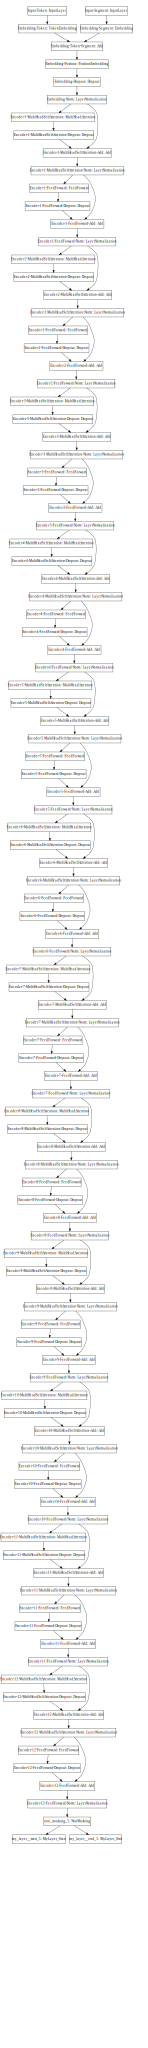

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


훈련을 시작

In [ ]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)
bert_model = get_bert_finetuning_model(model)
bert_model.summary()
history = bert_model.fit(train_x, train_y, batch_size=10, validation_split=0.05, shuffle=False, verbose=1)

In [ ]:
bert_model = get_bert_finetuning_model(model)
bert_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
___________________________________________________________________________________________

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/squad"

BERT MODEL을 저장

In [ ]:
bert_model.save_weights(path+"/squad_wordpiece.h5")

버트 모형을 다시 훈련함.
이번에는 validation_split을 입력하지 않아서 전체 데이터 훈련.

In [ ]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00003, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_x, train_y, batch_size=8, shuffle=False, verbose=1)

BERT MODEL 저장

In [ ]:
bert_model.save_weights(path+"/squad_wordpiece_2.h5")

버트 모형을 한번 더 훈련시켜 줌. learning_rate을 0.00001로 바꿔 줌.

In [ ]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00001, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_x, train_y, batch_size=8, shuffle=False, verbose=1)

BERT MODEL 저장

In [ ]:
bert_model.save_weights(path+"/squad_wordpiece_3.h5")

저장된 모델을 가져와서 BERT 모델로 저장함.

In [ ]:
!pip install h5py==2.10.0
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights("/content/drive/MyDrive/Colab Notebooks/squad/squad_wordpiece_3.h5")

bert_model1 = get_bert_finetuning_model(model)
bert_model1.load_weights("/content/drive/MyDrive/Colab Notebooks/squad/squad_wordpiece_2.h5")

Test data set에 대한 bert_input을 만들어 줌.

In [ ]:
def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

답을 예상하는 펑션정의

In [ ]:
def predict_letter(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

질문에 대한 답 예상

In [ ]:
doc = "태양계의 5번째 행성이며, 태양계의 행성 중 가장 부피가 크고 무겁다. 반지름은 지구의 11.2배, 부피는 지구의 1300배가 넘는다. 질량은 지구의 318배다. 부피에 비해 질량이 작은 이유는 암석형 행성보다 밀도가 낮은 성분들이 주요 구성성분인 가스형 행성이기 때문이다. 그럼에도 목성의 질량은 다른 태양계 행성들을 합친 것보다도 무겁다. 심지어 그 7개 행성의 질량을 몽땅 다 합쳐도 목성의 절반도 되지 않는다. 태양계에서 태양이 99.86%를 차지하고, 목성은 나머지 0.14% 중에서 약 2/3인 0.095%를 차지한다. 뒤를 이어 토성이 0.029%를 차지하며, 나머지 행성들을 모두 합쳐도 태양계 질량의 0.016% 정도 밖에 되지 않는다."
question = "목성의 부피는 지구의 몇배인가?"

predict_letter(question, doc)

Question :  목성의 부피는 지구의 몇배인가?
--------------------------------------------------
Context :  태양계의 5번째 행성이며, 태양계의 행성 중 가장 부피가 크고 무겁다. 반지름은 지구의 11.2배, 부피는 지구의 1300배가 넘는다. 질량은 지구의 318배다. 부피에 비해 질량이 작은 이유는 암석형 행성보다 밀도가 낮은 성분들이 주요 구성성분인 가스형 행성이기 때문
이다. 그럼에도 목성의 질량은 다른 태양계 행성들을 합친 것보다도 무겁다. 심지어 그 7개 행성의 질량을 몽땅 다 합쳐도 목성의 절반도 되지 않는다. 태양계에서 태양이 99.86%를 차지하고, 목성은 나머지 0.14% 중에서 약 2/3인 0.095%를 차지한다. 뒤를 
이어 토성이 0.029%를 차지하며, 나머지 행성들을 모두 합쳐도 태양계 질량의 0.016% 정도 밖에 되지 않는다.
--------------------------------------------------
ANSWER :  

1300 ##배 

Untokenized Answer :  1300배


KorQUAD 데이터 셋에서 test 용도로 쓰이는 dev 파일을 PANDAS DATAFRAME 형식으로 불러오는 함수를 정의함.

In [ ]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

DEV Json을 데이터 프레임으로 로딩함.

In [ ]:
input_file_path = path+'/KorQuAD_v1.0_dev.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (5774, 5)
Done


데이터 프레임 출력

In [ ]:
dev

,id,question,context,answers,c_id
0,6548850-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년 2월 15일', 'answer_start': 0}]",0
1,6548850-0-1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '임수경', 'answer_start': 125}]",0
2,6548853-0-0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '1989년', 'answer_start': 0}]",0
3,6548853-0-1,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '학생회관 건물 계단', 'answer_start': 365}]",0
4,6548853-0-2,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,"[{'text': '서울지방경찰청 공안분실', 'answer_start': 457}]",0
...,...,...,...,...,...
5769,6511152-4-0,중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생한 년도는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '2016년', 'answer_start': 0}]",959
5770,6511152-4-1,갤럭시 S7엣지를 만든 회사는?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '삼성전자', 'answer_start': 83}]",959
5771,6511152-4-2,2016년 9월 4일 갤럭시 S7엣지가 폭발한 사건이 발생한 지역은?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '중동 지역', 'answer_start': 12}]",959
5772,6535617-4-0,갤럭시 노트 7은 출시 며칠만에 기기 결함으로 터지기 시작하였나?,2016년 9월 4일 중동 지역에서 갤럭시 S7 엣지가 폭발하는 사건이 발생했다. ...,"[{'text': '18일', 'answer_start': 286}]",959


테스트 데이터에 대해서 결과를 확인

In [ ]:
import random
for i in random.sample(range(5),5):
  doc = dev['context'][i]
  question = dev['question'][i]
  answers = dev['answers'][i]
  predict_letter(question, doc)
  print("")
  print("real answer : ", answers)
  print("")

Question :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
--------------------------------------------------
Context :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가
 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대
학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서
울 장안동의 서울지방경찰청 공안분실로 인계되었다.
--------------------------------------------------
ANSWER :  

1989년 2월 15일 

Untokenized Answer :  1989년 2월 15일

real answer :  [{'text': '1989년 2월 15일', 'answer_start': 0}]

Question :  임종석이 1989년 2월 15일에 지명수배 받은 혐의는 어떤 시위를 주도했다는 것인가?
--------------------------------------------------
Context :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


test json을 데이터프레임으로 변경함.

In [ ]:
def squad_json_to_dataframe_test1(input_file_path, record_path = ['data''answers'],
                           verbose = 1):

    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
   
    if verbose:
        print("processing...")
   
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    

    return(m)

test json을 데이터 프레임으로 변경함.

In [ ]:
import pandas as pd
import numpy as np  
import re
import pickle


import codecs
from tqdm import tqdm
import shutil
import json

input_file_path = '/content/gdrive/MyDrive/Colab Notebooks/squad/test.json'
record_path = ['data','answers']
verbose = 0
train1 = squad_json_to_dataframe_test1(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...


test 데이터 프레임 출력

In [ ]:
train1

,context,id,question,title,answers.answer_start,answers.text
0,사회위해성이 있는 범죄라고 판단되는 행위에 대해서는 공안기관이 치안관리처벌법에 기초...,1,사회에 해를 끼치는 범죄에 대해서 공안기관이 근거로 삼는 법안은 무엇인가?,중화인민공화국의_법,[],
1,"이후 일본의 강요로 1943년 조선기독교단으로 강제 통합당한 감리교회는, 해방후 다...",1,전용재 목사가 감독회장에 당선된 연도는?,기독교대한감리회,[],
2,일반적으로 자유가동을 하는 대부분의 유기체들은 기본적으로 유사한 위상 반응 곡선 (...,1,생물학적 시계를 재조정할 수 있는 요소는 무엇인가?,활동일_주기,[],
3,"세 번째 외계인 종족은 스크린이라 알려져 있으며, 스크린은 지구에 뿌려둔 타이베리움...",1,스크린이 지구에서 가지러 온 물질은?,커맨드_앤_컨커_3__타이베리움_워,[],
4,"나경원은 2008년 8월 최시중 방송통신위원회장, 이동관 대변인과 함께 국정원 2차...",1,나경원이 정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부 개정법률안을 대표발의...,나경원,[],
...,...,...,...,...,...,...
111,"일반적 방식과 달리 1차 투표의 상위 2명뿐만 아니라, 상위 2명 안에는 들지 못하...",1,에른스트 델만의 참여는 어떤 인물이 1925년 대통령 선거에서 이기는데 도움이 되었는가?,결선투표제,[],
112,지난 2016년 4월13일 치러진 국회의원 선거에 출마한 현 이완영 의원등 당시 새...,1,국민을 대상으로 조건부 세비 반납 약속을 한 국회의원 후보는 몇 명인가?,이완영,[],
113,그는 유년기 시절 할아버지의 영향을 받았다고 한다. 손이 귀한 집의 독자로 태어난 ...,1,김영삼 대통령의 유년기 시절 그에게 영향을 미쳤던 가족은 누구인가?,김영삼,[],
114,"""나는 대통령 때 외무부에 지시해 독도 인근 해역에 배를 엄청나게 띄워 해상시위를 ...",1,당시 해상 시위를 하던 사람들이 비난한 정권은?,김영삼,[],


질문의 답을 예상한다. 3번째 모델을 로딩하여 예상한다.

In [ ]:
def predict_letter_return(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("\nQuestion : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  d = ""
  print("\n")
  print("Untokenized Answer : ", end = "")

  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
      d = d + w
    else:
      w = " " + w
      d =  d + w

    print(w, end="")

  return(d)

질문의 답을 예상함. 2번째 모델을 로딩하여 확인.

In [ ]:
def predict_letter_return1(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model1.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("\nQuestion : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  d = ""
  print("\n")
  print("Untokenized Answer : ", end = "")

  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
      d = d + w
    else:
      w = " " + w
      d =  d + w

    print(w, end="")

  return(d)

질문에 대한 답을 불러와 데이터 프레임으로 재구성함.

In [ ]:
my_answer = {}
my_answer['id']=[]
my_answer['prediction_text']=[]

for index, row in train1.iterrows():
    question = row["question"]
    context  = row["context"]
    answer   = predict_letter_return(question, context)
    
    if (len(answer) ==0 or len(answer) >= 50):
      answer   = predict_letter_return1(question, context)

    my_answer['id'].append(str(index + 1))
    my_answer['prediction_text'].append(answer.lstrip())


train3 = pd.DataFrame(my_answer)
train3.head()


Question :  사회에 해를 끼치는 범죄에 대해서 공안기관이 근거로 삼는 법안은 무엇인가?
--------------------------------------------------
Context :  사회위해성이 있는 범죄라고 판단되는 행위에 대해서는 공안기관이 치안관리처벌법에 기초하여, 경고, 과료, 행정구류, 허가증의 취소, 외국인에 대하여는 국외추방이라고 하는 치안관리처벌을 부과한다. 치안관리처벌의 결정은 행정불복심사의 신청이나 행정소송에 의하여 다툴 수 있다
. 그 외에, 일찍이 중국에는 법의 근거가 없는 행정처벌이나 법정의 절차를 준수하지 않는 행정처벌, 공포되지 않은 법령에 기초한 행정처벌을 볼 수 있었으나, 행정처벌법에는 이러한 행정처벌을 명문으로 금지하였다. 중국에는 일정한 직업을 가지지 아니한 자나 마약중독자 등에
 대한 근로교정도 행해지고 있다. 근로교정의 시간은 최장 4년에 이르러, 그 절차나 운영에 관한 비판이 고조되고 있다.
--------------------------------------------------
ANSWER :  

치 ##안 ##관 ##리 ##처 ##벌 ##법 

Untokenized Answer :  치안관리처벌법
Question :  전용재 목사가 감독회장에 당선된 연도는?
--------------------------------------------------
Context :  이후 일본의 강요로 1943년 조선기독교단으로 강제 통합당한 감리교회는, 해방후 다시 분리되어 새로 교단을 구성하는 과정에서 재건파와 복흥파로 분리되는 등 홍역을 앓았다. 그러나 그 이후 다시 통합되어 1949년 현재의 이름이 채택되었다. 이후 1971년 경기연회 사건
으로 총리원과 총회(갱신)측으로 분리되기도 하였으나[3], 이후 재통합돼 감리교단은 현재 대한민국 개신교 교파중에서 유일하게 교파 분열을 겪지 않은 교회이다. 다만 2008년 감독회장 선거로 시작된 기독교대한감리회 감독회장 선출 논쟁이 있었으나 2013년 현재

,id,prediction_text
0,1,치안관리처벌법
1,2,2013년
2,3,빛
3,4,
4,5,11월 3일


CSV파일로 만들어 케라스 리더보드에 올릴 값을 파일을 만듦

In [ ]:
train3.to_csv('my_answer.csv', index=False, encoding='utf-8')

In [ ]:
train3